In [1]:
from __future__ import division
import pickle
import os
import types
import random
import uuid
import math
from copy import deepcopy as copy

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import numpy as np
import tensorflow as tf
from scipy.misc import logsumexp

In [2]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rc('savefig', dpi=300)
# mpl.rc('text', usetex=True)

In [4]:
data_dir = os.path.join('data', 'cont-nav-idl')

In [5]:
sess = tf.Session()

create envs, pilot policies

In [6]:
n_train_tasks = 49
n_act_dim = 4
n_obs_dim = 4
gamma = 0.99
max_ep_len = 200
accel = 0.01
goal_dist_thresh = 2*accel
succ_rew_bonus = 1
crash_rew_penalty = -1
max_speed = 10*accel

In [7]:
is_succ = lambda r: r[-1][2] > succ_rew_bonus / 2
is_crash = lambda r: r[-1][2] < crash_rew_penalty / 2

In [8]:
train_goals = np.random.random((n_train_tasks, 2))

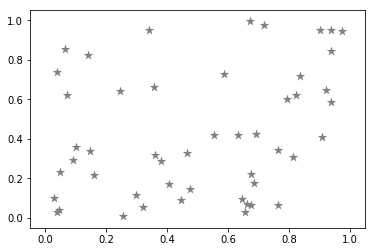

In [9]:
plt.scatter(train_goals[:, 0], train_goals[:, 1], linewidth=0, color='gray', s=100, marker='*')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

In [10]:
# with open(os.path.join(data_dir, 'train_goals.pkl'), 'wb') as f:
#   pickle.dump(train_goals, f, pickle.HIGHEST_PROTOCOL)

In [11]:
with open(os.path.join(data_dir, 'train_goals.pkl'), 'rb') as f:
  train_goals = pickle.load(f)

In [12]:
def make_reward_func(goal):

  def reward_shaping(obs):
    return -np.linalg.norm((obs[:2] - goal))

  def reward_func(prev_obs, action, obs):
    pos = obs[:2]
    if (pos < 0).any() or (pos >= 1).any():
      r = crash_rew_penalty
    elif (np.abs(pos - goal) <= goal_dist_thresh).all():
      r = succ_rew_bonus
    else:
      r = gamma * reward_shaping(obs) - reward_shaping(prev_obs)
    return r
  
  return reward_func

In [13]:
class PointMassNav(gym.Env):
  metadata = {
    'render.modes': ['human']
  }
  
  def __init__(
      self, 
      using_inertia=True,
      max_ep_len=max_ep_len, 
      reward_func=None,
      goal=None,
      rand_goal=False,
      expose_goal=False
    ):
    
    self.expose_goal = expose_goal
    if self.expose_goal:
      lows = np.ones(n_obs_dim + 2) * -1
      highs = np.ones(n_obs_dim + 2) * 2
    else:
      lows = np.ones(n_obs_dim) * -1
      highs = np.ones(n_obs_dim) * 2
      
    self.observation_space = spaces.Box(lows, highs, dtype=np.float32)
    self.action_space = spaces.Discrete(n_act_dim)
    
    self.pos = None
    self.vel = None
    self.curr_step = None
    self.viewer = None
    self.curr_obs = None
    
    self.succ_rew_bonus = succ_rew_bonus
    self.max_ep_len = max_ep_len
    self.reward_func = reward_func
    self.using_inertia = using_inertia
    self.goal = goal
    self.rand_goal = rand_goal
    
  def copy(self):
    new_env = PointMassNav(using_inertia=self.using_inertia,
                       max_ep_len=self.max_ep_len,
                       reward_func=self.reward_func,
                       goal=self.goal,
                       rand_goal=self.rand_goal,
                       expose_goal=self.expose_goal)
    new_env.pos = copy(self.pos)
    new_env.vel = copy(self.vel)
    new_env.curr_step = copy(self.curr_step)
    new_env.curr_obs = copy(self.curr_obs)
    return new_env
    
  def _obs_of_pos_vel(self, pos, vel):
    if self.expose_goal:
      return np.concatenate((pos, vel, self.goal))
    else:
      return np.concatenate((pos, vel))
    
  def obs(self):
    self.curr_obs = self._obs_of_pos_vel(self.pos, self.vel)
    return self.curr_obs

      
  
  def _next_pos_vel(self, pos, vel, action):
    next_pos = copy(pos)
    if self.using_inertia:
      next_vel = copy(vel)
    else:
      next_vel = np.zeros(2)
      
    if action == 0: # left
      next_vel[1] -= accel
    elif action == 1: # right
      next_vel[1] += accel
    elif action == 2: # up
      next_vel[0] -= accel
    elif action == 3: # down
      next_vel[0] += accel
    else:
      raise ValueError('invalid action')
      
    next_vel = np.maximum(np.minimum(next_vel, max_speed), -max_speed)
    next_pos += next_vel
    
    return next_pos, next_vel



  def step(self, action):  
    self.pos, self.vel = self._next_pos_vel(self.pos, self.vel, action)
        
    self.curr_step += 1
    succ = (np.abs(self.pos - self.goal) <= goal_dist_thresh).all()
    oob = (self.pos < 0).any() or (self.pos >= 1).any()
    oot = self.curr_step >= self.max_ep_len
    
    obs = self.obs()
    r = self.reward_func(self.prev_obs, action, obs)
    done = oot or succ or oob
    info = {}
      
    self.prev_obs = obs
    
    return obs, r, done, info
    
  def reset(self):
    self.pos = np.random.random(2)
    self.vel = np.zeros(2)
    
    if self.rand_goal:
      self.goal = np.random.random(2)
      self.reward_func = make_reward_func(self.goal)
    self.curr_step = 0
    self.prev_obs = self.obs()
    return self.prev_obs
  
  def render(self, mode='human', close=False):
    if close:
      if self.viewer is not None:
        self.viewer.close()
        self.viewer = None
      return
    
    if self.viewer is None:
      self.viewer = rendering.SimpleImageViewer()
    
    fig = plt.figure()
    canvas = FigureCanvas(fig)
    
    plt.scatter([self.goal[0]], [self.goal[1]], color='gray', linewidth=0, alpha=0.75, marker='*')
    plt.scatter([self.pos[0]], [self.pos[1]], color='orange', linewidth=0, alpha=0.75)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.axis('off')
    
    agg = canvas.switch_backends(FigureCanvas)
    agg.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    self.viewer.imshow(np.fromstring(agg.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3))
    plt.close()

In [14]:
train_reward_funcs = [make_reward_func(goal) for goal in train_goals]
train_newton_envs = [PointMassNav(reward_func=r, goal=train_goals[i], using_inertia=True) for i, r in enumerate(train_reward_funcs)]
train_aristotle_envs = [PointMassNav(reward_func=r, goal=train_goals[i], using_inertia=False) for i, r in enumerate(train_reward_funcs)]

In [15]:
def run_ep(policy, env, max_ep_len=max_ep_len, render=False, task_idx=None):
  obs = env.reset()
  done = False
  totalr = 0.
  prev_obs = obs
  rollout = []
  for step_idx in range(max_ep_len+1):
    if done:
      break
    action = policy(obs)
    obs, r, done, info = env.step(action)
    rollout.append((prev_obs, action, r, obs, float(done), task_idx))
    prev_obs = obs
    if render:
      env.render()
    totalr += r
  return rollout

In [16]:
def make_aristotle_pilot_policy(goal, denoise=False):
  eps = accel if denoise else 0
  gx, gy = goal
  def aristotle_pilot_policy(obs):
    x, y = obs[:2]
    up = gx<x-eps
    down = gx>x+eps
    left = gy<y-eps
    right = gy>y+eps
    lr = left or right
    ud = up or down
    if lr and (not ud or np.random.random() < 0.5):
      if left:
        return 0
      elif right:
        return 1
    elif ud:
      if up:
        return 2
      elif down:
        return 3
    return 0
  return aristotle_pilot_policy

In [17]:
def make_newton_pilot_policy(env, beta=10, vel_penalty=0.2):
  gx, gy = env.goal
  nA = 4
    
  def next_vel(vel, action):
    next_vel = copy(vel)  
    if action == 0: # left
      next_vel[1] -= accel
    elif action == 1: # right
      next_vel[1] += accel
    elif action == 2: # up
      next_vel[0] -= accel
    elif action == 3: # down
      next_vel[0] += accel
    else:
      raise ValueError('invalid action')
      
    next_vel = np.maximum(np.minimum(next_vel, max_speed), -max_speed)
    
    return next_vel

  def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))
  
  def newton_pilot_policy(obs):
    x, y, dx, dy = obs
    vel = np.array([dx,dy])
    x_diff = gx-x
    y_diff = gy-y
    true_vec = np.array([x_diff,y_diff])
    vel_vecs = np.array([next_vel(vel,a) for a in range(nA)])
    angle_diffs = np.dot(true_vec + vel_vecs, true_vec)
    action_weights = (angle_diffs - vel_penalty * np.linalg.norm(vel_vecs, axis=1))
    return np.random.choice(np.asarray(range(nA)),p=softmax(beta * action_weights))

  return newton_pilot_policy

In [18]:
aristotle_pilot_policies = [make_aristotle_pilot_policy(goal,denoise=True) for goal in train_goals]

In [19]:
newton_pilot_policies = [make_newton_pilot_policy(env, 1000) for env in train_newton_envs]

sanity-check envs, agents

In [20]:
train_task_idx = 0

In [21]:
# run_ep(aristotle_pilot_policies[train_task_idx], train_aristotle_envs[train_task_idx], render=True)

In [22]:
# train_aristotle_envs[train_task_idx].close()

In [23]:
# run_ep(newton_pilot_policies[train_task_idx], train_newton_envs[train_task_idx], render=True)

In [24]:
# train_newton_envs[train_task_idx].close()

fit internal dynamics model

In [25]:
n_train_rollouts_per_env = 1000

In [26]:
# demo_rollouts = [[run_ep(newton_pilot_policies[train_task_idx], newton_env, render=False, task_idx=train_task_idx)
#                   for _ in range(n_train_rollouts_per_env)]
#                  for train_task_idx, newton_env in enumerate(train_newton_envs)]

In [27]:
# with open(os.path.join(data_dir, 'newton_pilot_policy_demo_rollouts.pkl'), 'wb') as f:
#   pickle.dump(demo_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [28]:
with open(os.path.join(data_dir, 'newton_pilot_policy_demo_rollouts.pkl'), 'rb') as f:
  demo_rollouts = pickle.load(f)

In [29]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
  ):
  out = input_placeholder
  with tf.variable_scope(scope, reuse=reuse):
    for _ in range(n_layers):
      out = tf.layers.dense(out, size, activation=activation)
    out = tf.layers.dense(out, output_size, activation=output_activation)
  return out

In [30]:
def onehot_encode(i, n):
  x = np.zeros(n)
  x[i] = 1
  return x

def onehot_decode(x):
  l = np.nonzero(x)[0]
  assert len(l) == 1
  return l[0]

n_obs_feats = n_obs_dim
def featurize_obs(s):
  return s

n_act_feats = 2
feats_of_act = np.array([
  [0, -1],
  [0, 1],
  [-1, 0],
  [1, 0]
], dtype=float) * accel
def featurize_act(a):
  return feats_of_act[a, :]

In [31]:
def vectorize_rollouts(rollouts):
  obs = [[] for _ in range(n_train_tasks)]
  actions = [[] for _ in range(n_train_tasks)]
  next_obs = [[] for _ in range(n_train_tasks)]
  for task_idx, task_rollouts in enumerate(rollouts):
    for task_rollout in task_rollouts:
      more_obs, more_actions, _, more_next_obs = list(zip(*task_rollout))[:4]
      obs[task_idx].extend([featurize_obs(s) for s in more_obs])
      actions[task_idx].extend(more_actions)
      next_obs[task_idx].extend([featurize_obs(s) for s in more_next_obs])
  l = min(len(x) for x in obs)
  idxes = [random.sample(list(range(len(x))), l) for x in obs]
  f = lambda x: np.array(x[1])[idxes[x[0]]]
  obs = np.array(list(map(f, enumerate(obs))))
  actions = np.array(list(map(f, enumerate(actions))))
  action_feats = np.array([featurize_act(a) for a in actions])
  next_obs = np.array(list(map(f, enumerate(next_obs))))
  return obs, actions, action_feats, next_obs

In [32]:
demo_obs = None
demo_actions = None
demo_action_feats = None
demo_next_obs = None
demo_task_idxes = None
train_demo_example_idxes = None
val_demo_batch = None

In [33]:
def process_demo_rollouts(demo_rollouts):
  global demo_obs
  global demo_actions
  global demo_action_feats
  global demo_next_obs
  global demo_task_idxes
  global train_demo_example_idxes
  global val_demo_batch

  
  demo_obs, demo_actions, demo_action_feats, demo_next_obs = vectorize_rollouts(demo_rollouts)
  demo_example_idxes = list(range(demo_obs.shape[1]))
  
  random.shuffle(demo_example_idxes)
  n_train_demo_examples = int(0.9 * len(demo_example_idxes))
  train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
  val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
  val_demo_batch = (demo_obs[:, val_demo_example_idxes], demo_actions[:, val_demo_example_idxes],
        demo_action_feats[:, val_demo_example_idxes], demo_next_obs[:, val_demo_example_idxes])

In [34]:
process_demo_rollouts(demo_rollouts)

In [35]:
def sample_batch(size):
  idxes = random.sample(train_demo_example_idxes, size)
  demo_batch = (demo_obs[:, idxes], demo_actions[:, idxes], demo_action_feats[:,idxes], demo_next_obs[:, idxes])
  return demo_batch

In [36]:
gamma = 0.99
iterations = 100000
learning_rate = 1e-3
batch_size = 512 // n_train_tasks
sq_td_err_penalty = 1e0
trans_err_penalty = 1e0

q_n_layers = 1
q_layer_size = 32
q_activation = tf.nn.relu
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 32
invdyn_activation = tf.nn.relu
invdyn_output_activation = None

constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 500

val_update_freq = 100
n_val_eval_rollouts = 100

In [37]:
im_scope = str(uuid.uuid4())
q_scope = str(uuid.uuid4())
invdyn_scope = str(uuid.uuid4())

In [38]:
demo_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats])
demo_act_t_ph = tf.placeholder(tf.int32, [n_train_tasks, None])
demo_act_t_feats_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_act_feats])
demo_next_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats])
demo_batch_size_ph = tf.placeholder(tf.int32)

constraint_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats])
constraint_act_t_ph = tf.placeholder(tf.int32, [n_train_tasks, None])
constraint_act_t_feats_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_act_feats])
constraint_batch_size_ph = tf.placeholder(tf.int32)

In [39]:
demo_batch_idxes = tf.reshape(
  tf.range(0, demo_batch_size_ph, 1), 
  [demo_batch_size_ph, 1])

extract_task = lambda x, i: tf.squeeze(tf.gather(x, tf.convert_to_tensor(
  [i], dtype=tf.int32)), axis=[0]) 

demo_q_t = tf.stack([tf.gather_nd(
  build_mlp(
    extract_task(demo_obs_t_ph, train_task_idx),
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation
  ), 
  tf.concat([
    demo_batch_idxes, 
    tf.expand_dims(extract_task(demo_act_t_ph, train_task_idx), 1)], axis=1)
) for train_task_idx in range(n_train_tasks)], axis=0)

demo_v_t = tf.reduce_logsumexp(
  tf.stack([build_mlp(
    extract_task(demo_obs_t_ph, train_task_idx),
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True
  ) for train_task_idx in range(n_train_tasks)], axis=0),
  axis=2)

act_log_likelihoods = demo_q_t - demo_v_t

In [40]:
neg_avg_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [41]:
constraint_act_t_feats_reshaped = tf.reshape(
  constraint_act_t_feats_ph, [n_train_tasks*constraint_batch_size_ph, n_act_feats])

constraint_obs_t_reshaped = tf.reshape(
  constraint_obs_t_ph, [n_train_tasks*constraint_batch_size_ph, n_obs_feats])

demo_act_t_feats_reshaped = tf.reshape(
  demo_act_t_feats_ph, [n_train_tasks*demo_batch_size_ph, n_act_feats])

demo_obs_t_reshaped = tf.reshape(
  demo_obs_t_ph, [n_train_tasks*demo_batch_size_ph, n_obs_feats])

demo_next_obs_t_reshaped = tf.reshape(
  demo_next_obs_t_ph, [n_train_tasks, demo_batch_size_ph, n_obs_feats])

In [42]:
assert n_obs_feats == 4
assert n_act_feats == 2

In [43]:
int_dyn_A_fixed = np.zeros((n_obs_feats, 2))
int_dyn_A_fixed[[0, 1], [0, 1]] = 1

int_dyn_A_top = np.zeros((2, 2))
int_dyn_A_top[[0, 1], [0, 1]] = 1
int_dyn_A_top = tf.convert_to_tensor(int_dyn_A_top, tf.float32)
int_dyn_A_top *= 1 / (1 + tf.exp(-tf.get_variable(
  im_scope + '-A-top', [1], 
  initializer=tf.random_normal_initializer)))

int_dyn_A_bot = np.zeros((2, 2))
int_dyn_A_bot[[0, 1], [0, 1]] = 1
int_dyn_A_bot = tf.convert_to_tensor(int_dyn_A_bot, tf.float32)
int_dyn_A_bot *= 1 / (1 + tf.exp(-tf.get_variable(
  im_scope + '-A-bot', [1],
  initializer=tf.random_normal_initializer)))

int_dyn_A = tf.concat([
  tf.convert_to_tensor(int_dyn_A_fixed, tf.float32), 
  tf.concat([int_dyn_A_top, int_dyn_A_bot], axis=0)
], axis=1)

In [44]:
int_dyn_B_vel = np.zeros((n_obs_feats, n_act_feats))
int_dyn_B_vel[[0, 1], [0, 1]] = 1
int_dyn_B_vel = tf.convert_to_tensor(int_dyn_B_vel, tf.float32)

int_dyn_B_acc = np.zeros((n_obs_feats, n_act_feats))
int_dyn_B_acc[[2, 3], [0, 1]] = 1
int_dyn_B_acc = tf.convert_to_tensor(int_dyn_B_acc, tf.float32)

int_dyn_B_switch = 1 / (1 + tf.exp(-tf.get_variable(
  im_scope+'-B', [1], 
  initializer=tf.random_normal_initializer)))

int_dyn_B = int_dyn_B_switch * int_dyn_B_vel + (1 - int_dyn_B_switch) * int_dyn_B_acc

In [45]:
int_dyn_A_mask = np.zeros((n_obs_feats, n_obs_feats))
mask_idxes = [[0, 0], [0, 2], [1, 1], [1, 3], [2, 2], [3, 3]]
for x, y in mask_idxes:
  int_dyn_A_mask[x, y] = 1
int_dyn_A *= int_dyn_A_mask

int_dyn_B_mask = np.zeros((n_obs_feats, n_act_feats))
mask_idxes = [[0, 0], [1, 1], [2, 0], [3, 1]]
for x, y in mask_idxes:
  int_dyn_B_mask[x, y] = 1
int_dyn_B *= int_dyn_B_mask

In [46]:
# Predicted demo next state
demo_pred_next_obs_t_reshaped = tf.reshape(
  tf.transpose(tf.matmul(int_dyn_A, tf.transpose(
  demo_obs_t_reshaped)) + tf.matmul(int_dyn_B, tf.transpose(
  demo_act_t_feats_reshaped))), 
  [n_train_tasks, demo_batch_size_ph, n_obs_feats])

In [47]:
trans_err = demo_pred_next_obs_t_reshaped - demo_next_obs_t_reshaped

In [48]:
sq_trans_err = tf.reduce_mean(trans_err**2)

In [49]:
# Predicted constraint next state given inv dyns
constraint_obs_tp1 = tf.reshape(
  tf.transpose(tf.matmul(int_dyn_A, tf.transpose(
  constraint_obs_t_reshaped)) + tf.matmul(int_dyn_B, tf.transpose(
  constraint_act_t_feats_reshaped))), 
  [n_train_tasks, constraint_batch_size_ph, n_obs_feats])

In [50]:
# Predicted next state q-vals
q_tp1 = tf.stack([build_mlp(
  extract_task(constraint_obs_tp1, train_task_idx),
  n_act_dim, q_scope+'-'+str(train_task_idx), 
  n_layers=q_n_layers, size=q_layer_size,
  activation=q_activation, output_activation=q_output_activation, 
  reuse=True) for train_task_idx in range(n_train_tasks)], axis=0)
v_tp1 = tf.reduce_logsumexp(q_tp1, axis=2)

In [51]:
# Predicted next state rewards
rew_ts = []
for train_task_idx in range(n_train_tasks):
  goal_x = tf.convert_to_tensor(train_goals[train_task_idx, 0], dtype=tf.float32)
  goal_y = tf.convert_to_tensor(train_goals[train_task_idx, 1], dtype=tf.float32)
  
  constraint_obs_tp1_of_task = extract_task(constraint_obs_tp1, train_task_idx)
  constraint_obs_t_of_task = extract_task(constraint_obs_t_ph, train_task_idx)

  pos_x_tp1 = tf.gather(constraint_obs_tp1_of_task, tf.convert_to_tensor(
    [0], dtype=tf.int32), axis=1)
  
  pos_y_tp1 = tf.gather(constraint_obs_tp1_of_task, tf.convert_to_tensor(
    [1], dtype=tf.int32), axis=1)
  
  pos_x_t = tf.gather(constraint_obs_t_of_task, tf.convert_to_tensor(
    [0], dtype=tf.int32), axis=1)
  
  pos_y_t = tf.gather(constraint_obs_t_of_task, tf.convert_to_tensor(
    [1], dtype=tf.int32), axis=1)

  dist_to_goal_t = tf.sqrt((pos_x_t-goal_x)**2+(pos_y_t-goal_y)**2)
  dist_to_goal_tp1 = tf.sqrt((pos_x_tp1-goal_x)**2+(pos_y_tp1-goal_y)**2)

  crashed_t = tf.logical_or(tf.logical_or(tf.logical_or(
    pos_x_tp1 < 0, pos_y_tp1 < 0), pos_x_tp1 >= 1), pos_y_tp1 >= 1)
  succed_t = tf.logical_and(
    tf.abs(pos_x_tp1-goal_x) <= goal_dist_thresh, 
    tf.abs(pos_y_tp1-goal_y) <= goal_dist_thresh)

  rew_t = -gamma*dist_to_goal_tp1 + dist_to_goal_t
  rew_t += crash_rew_penalty * tf.cast(crashed_t, tf.float32)
  rew_t += succ_rew_bonus * tf.cast(tf.logical_and(tf.logical_not(crashed_t), succed_t), tf.float32)
  rew_t = tf.squeeze(rew_t)
  
  rew_ts.append(rew_t)
rew_t = tf.stack(rew_ts, axis=0)

In [52]:
# TD vals
target_t = rew_t + gamma * v_tp1

In [53]:
constraint_batch_idxes = tf.reshape(
  tf.range(0, constraint_batch_size_ph, 1), 
  [constraint_batch_size_ph, 1])

# Sampled constraint state q-vals
q_t = tf.stack([tf.gather_nd(
  build_mlp(
    extract_task(constraint_obs_t_ph, train_task_idx), 
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation, 
    reuse=True
  ), 
  tf.concat([
    constraint_batch_idxes, 
    tf.expand_dims(extract_task(constraint_act_t_ph, train_task_idx), 1)], axis=1)
) for train_task_idx in range(n_train_tasks)], axis=0)

In [54]:
# Bellman errors
td_err = q_t - target_t

In [55]:
sq_td_err = tf.reduce_mean(td_err**2)

In [56]:
loss = neg_avg_log_likelihood + sq_td_err_penalty * sq_td_err + trans_err_penalty * sq_trans_err

In [57]:
trans_loss = sq_trans_err

In [58]:
full_update_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [59]:
trans_update_op = tf.train.AdamOptimizer(learning_rate).minimize(trans_loss)

In [60]:
samp_obs_t_ph = tf.placeholder(tf.float32, [None, n_obs_feats])
samp_act_t_feats_ph = tf.placeholder(tf.float32, [None, n_act_feats])

samp_q_t = [build_mlp(
  samp_obs_t_ph, 
  n_act_dim, q_scope + '-' + str(train_task_idx), 
  n_layers = q_n_layers, size = q_layer_size,
  activation=q_activation, output_activation=q_output_activation, 
  reuse=True
) for train_task_idx in range(n_train_tasks)]

# samp_obs_tp1 = build_mlp(
#     tf.concat(samp_obs_t_ph, samp_act_t_feats_ph),
#     n_obs_feats,
#     invdyn_scope,
#     n_layers = invdyn_n_layers,
#     size = invdyn_size,
#     activation = invdyn_activation
#     output_activation = invdyn_output_activation
#     reuse=False)
    

samp_obs_tp1 = tf.transpose(tf.matmul(int_dyn_A, tf.transpose(
  samp_obs_t_ph)) + tf.matmul(int_dyn_B, tf.transpose(
  samp_act_t_feats_ph)))

In [61]:
def make_val_assisted_env():
  test_goal = np.random.random(2)
  test_reward_func = make_reward_func(test_goal)
  test_aristotle_pilot_policy = make_aristotle_pilot_policy(test_goal, denoise=True)
  env = PointMassNav(using_inertia=True, reward_func=test_reward_func, goal=test_goal)
  return test_aristotle_pilot_policy, env

def compute_assisted_perf(): 
  assisted_rollouts = [[] for _ in range(n_val_eval_rollouts)]
  test_aristotle_pilot_policies, envs = zip(*[make_val_assisted_env(
    ) for _ in range(n_val_eval_rollouts)])
  obses = np.array([env.reset() for env in envs])
  dones = [False for _ in envs]
  prev_obses = obses
  for step_idx in range(max_ep_len+1):
    not_done_idxes = [i for i, done in enumerate(dones) if not done]
    if not_done_idxes == []:
      break
    act_feats = np.array([featurize_act(
      test_aristotle_pilot_policies[i](obses[i])) for i in not_done_idxes])
    obs_feats = np.array(
      [featurize_obs(obses[i]) for i in not_done_idxes])
    feed_dict = {
      samp_obs_t_ph: obs_feats,
      samp_act_t_feats_ph: act_feats
    }
    intended_obses = sess.run(samp_obs_tp1, feed_dict=feed_dict)

    intended_actions = [inverse_real_dyn(
      obs_feats[i], intended_obses[i]) for i in range(len(not_done_idxes))]

    for i, env_idx in enumerate(not_done_idxes):
      action = intended_actions[i]
      obs, r, done, info = envs[env_idx].step(action)
      obses[env_idx] = obs
      dones[env_idx] = done
      assisted_rollouts[env_idx].append((prev_obses[env_idx], None, r, obs, float(done), None))
    prev_obses = copy(obses)

  assisted_rew = np.mean([sum(x[2] for x in r) for r in assisted_rollouts])
  assisted_succ = np.mean([1 if is_succ(r) else 0 for r in assisted_rollouts])
  assisted_crash = np.mean([1 if is_crash(r) else 0 for r in assisted_rollouts])
  assisted_perf = {
    'assisted_rew': assisted_rew,
    'assisted_succ': assisted_succ,
    'assisted_crash': assisted_crash
  }
  return assisted_perf

In [62]:
int_dyn_A_true = np.zeros((n_obs_feats, n_obs_feats))
int_dyn_A_true[[0, 0, 1, 1], [0, 2, 1, 3]] = 1
int_dyn_B_true = np.zeros((n_obs_feats, 2))
int_dyn_B_true[[0, 1], [0, 1]] = 1
def compute_int_dyn_err():
  int_dyn_A_eval = sess.run(int_dyn_A)
  int_dyn_B_eval = sess.run(int_dyn_B)
  return {'int_dyn_err': 
          np.linalg.norm(int_dyn_A_true - int_dyn_A_eval) + np.linalg.norm(
            int_dyn_B_true - int_dyn_B_eval)}

In [63]:
def sample_constraints(_):
  constraint_rollouts = [[] for _ in range(n_train_tasks)]

  for train_task_idx in range(n_train_tasks):
    rollouts = [[] for _ in range(n_constraint_rollouts_per_env)]
    envs = [train_newton_envs[train_task_idx].copy() for _ in range(n_constraint_rollouts_per_env)]
    obses = np.array([env.reset() for env in envs])
    dones = [False for _ in envs]
    prev_obses = obses
    for step_idx in range(max_ep_len+1):
      not_done_idxes = [i for i, done in enumerate(dones) if not done]
      batch_size = len(not_done_idxes)
      if batch_size == 0:
        break
      actions = np.random.choice(n_act_dim, batch_size)
      for i, env_idx in enumerate(not_done_idxes):
        env = envs[env_idx]
        action = actions[i]
        obs, r, done, info = env.step(action)
        obses[env_idx] = obs
        dones[env_idx] = done
        rollouts[env_idx].append((prev_obses[env_idx], action))
      prev_obses = copy(obses)
    constraint_rollouts[train_task_idx].extend([r for r in rollouts if r != []])

  size = min(sum(len(r) for r in rollouts) for rollouts in constraint_rollouts)
  
  global train_constraint_example_idxes
  global val_constraint_batch
  global constraint_obs_t
  global constraint_act_t
  global constraint_act_t_feats
    
  constraint_obs_t = np.zeros((n_train_tasks, size, n_obs_feats))
  constraint_act_t = np.zeros((n_train_tasks, size))
  constraint_act_t_feats = np.zeros((n_train_tasks, size, n_act_feats))
  
  for train_task_idx in range(n_train_tasks):
    unfeat_obses, actions = list(zip(*sum(
      constraint_rollouts[train_task_idx], [])))
    obses = [featurize_obs(s) for s in unfeat_obses]
    act_feats = [featurize_act(a) for a in actions]
    idxes = random.sample(list(range(len(obses))), size)
    constraint_obs_t[train_task_idx, :, :] = np.array(obses)[idxes, :]
    constraint_act_t[train_task_idx, :] = np.array(actions)[idxes]
    constraint_act_t_feats[train_task_idx, :, :] = np.array(act_feats)[idxes, :]
  
  constraint_example_idxes = list(range(size))
  random.shuffle(constraint_example_idxes)
  n_train_constraint_examples = int(0.9 * size)
  
  train_constraint_example_idxes = constraint_example_idxes[:n_train_constraint_examples]
  val_constraint_example_idxes = constraint_example_idxes[n_train_constraint_examples:]
  val_constraint_batch = constraint_obs_t[:, val_constraint_example_idxes], constraint_act_t[:, val_constraint_example_idxes], constraint_act_t_feats[:, val_constraint_example_idxes]

In [64]:
def sample_constraint_batch(size):
  global n_iters_since_prev_constraint_sample
  if n_iters_since_prev_constraint_sample % constraint_sampling_freq == 0:
    sample_constraints(size)
    n_iters_since_prev_constraint_sample = 0
  n_iters_since_prev_constraint_sample += 1

  idxes = random.sample(train_constraint_example_idxes, size)
  constraint_batch = constraint_obs_t[:, idxes], constraint_act_t[:, idxes], constraint_act_t_feats[:, idxes]
  return constraint_batch

In [65]:
train_constraint_example_idxes = None
val_constraint_batch = None
constraint_obs_t = None
constraint_act_t = None
constraint_act_t_feats = None
n_iters_since_prev_constraint_sample = 0

In [66]:
tf.global_variables_initializer().run(session=sess)

In [ ]:
n_iters = iterations * demo_obs.shape[1] // batch_size
full_train_logs = {
  'loss_evals': [],
  'nll_evals': [],
  'ste_evals': [],
  'val_loss_evals': [],
  'val_nll_evals': [],
  'val_ste_evals': [],
  'int_dyn_err_evals': []
}

In [72]:
def compute_batch_loss(demo_batch, constraint_batch, trans_only=False, step=False, t=None):
  demo_batch_obs_t, demo_batch_act_t, demo_batch_act_t_feats, demo_batch_next_obs_t = demo_batch
  constraint_batch_obs_t, constraint_batch_act_t, constraint_batch_act_t_feats = constraint_batch
    
  feed_dict = {
    demo_obs_t_ph: demo_batch_obs_t,
    demo_act_t_ph: demo_batch_act_t,
    demo_act_t_feats_ph: demo_batch_act_t_feats,
    demo_next_obs_t_ph: demo_batch_next_obs_t,
    demo_batch_size_ph: demo_batch_obs_t.shape[1],
    constraint_obs_t_ph: constraint_batch_obs_t,
    constraint_act_t_ph: constraint_batch_act_t,
    constraint_act_t_feats_ph: constraint_batch_act_t_feats,
    constraint_batch_size_ph: constraint_batch_obs_t.shape[1],
  }
  
#   [loss_eval, neg_avg_log_likelihood_eval, sq_td_err_eval, sq_trans_err_eval] = sess.run(
#     [loss, neg_avg_log_likelihood, sq_td_err, sq_trans_err], feed_dict=feed_dict)
  if trans_only:
    [loss_eval] = sess.run([trans_loss], feed_dict=feed_dict)
    update_op = trans_update_op
    d = {
    'loss': loss_eval,
      }
  else:
    [loss_eval, neg_avg_log_likelihood_eval, sq_td_err_eval] = sess.run(
        [loss, neg_avg_log_likelihood, sq_td_err], feed_dict=feed_dict)
    update_op = full_update_op
    d = {
        'loss': loss_eval,
        'nll': neg_avg_log_likelihood_eval,
        'ste': sq_td_err_eval
      }
  
  if step:
    sess.run(update_op, feed_dict=feed_dict)
  


  return d

In [ ]:
val_log = None

In [ ]:
while len(full_train_logs['loss_evals']) < n_iters:
  demo_batch = sample_batch(batch_size)
  constraint_batch = sample_constraint_batch(constraint_batch_size)
  
  t = len(full_train_logs['loss_evals'])
  train_log = compute_batch_loss(demo_batch, constraint_batch, step=True, t=t)
  if val_log is None or len(full_train_logs['loss_evals']) % val_update_freq == 0:
    val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, step=False, t=t)
  
  if len(full_train_logs['loss_evals']) % 1000 == 0:
      print('%d %d %f %f %f %f %f %f' % (
        t, n_iters, train_log['loss'],
        train_log['nll'], train_log['ste'], val_log['loss'],
        val_log['nll'], val_log['ste'])
      )
  
  for k, v in train_log.items():
    full_train_logs['%s_evals' % k].append(v)
  for k, v in val_log.items():
    full_train_logs['%s%s_evals' % ('val_' if k in ['loss', 'nll', 'ste'] else '', k)].append(v)
  if len(full_train_logs['loss_evals']) % 10000 == 0:
    for k in ['val_nll_evals', 'val_ste_evals']:
      plt.xlabel('Iterations')
      plt.ylabel(k.split('_')[1])
      plt.plot(full_train_logs[k])
      plt.show()

In [ ]:
for k in ['val_nll_evals', 'val_ste_evals']:
  plt.xlabel('Iterations')
  plt.ylabel(k.split('_')[1])
  plt.plot(full_train_logs[k])
  plt.show()

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('L2 Error')
plt.plot(train_logs['int_dyn_err_evals'], color='orange')
plt.ylim([-0.05, None])
plt.show()

In [ ]:
print(sess.run(int_dyn_A))

In [ ]:
print(sess.run(int_dyn_B))

In [76]:
train_constraint_example_idxes = None
val_constraint_batch = None
constraint_obs_t = None
constraint_act_t = None
constraint_act_t_feats = None
n_iters_since_prev_constraint_sample = 0

tf.global_variables_initializer().run(session=sess)

n_iters = iterations * demo_obs.shape[1] // batch_size

trans_train_logs = {
  'loss_evals': [],
  'nll_evals': [],
  'ste_evals': [],
  'val_loss_evals': [],
  'val_nll_evals': [],
  'val_ste_evals': [],
  'int_dyn_err_evals': []
}
val_log = None

89000 195210000 0.000225 0.000250


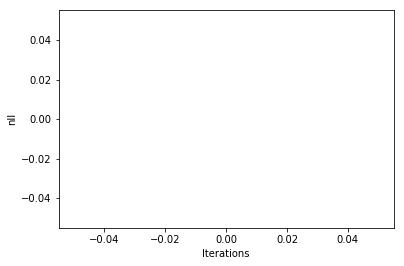

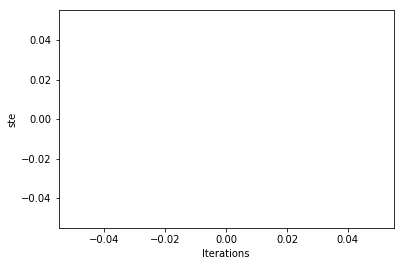

90000 195210000 0.000174 0.000157
91000 195210000 0.000081 0.000078
92000 195210000 0.000049 0.000046
93000 195210000 0.000037 0.000035
94000 195210000 0.000029 0.000030
95000 195210000 0.000027 0.000027
96000 195210000 0.000026 0.000026
97000 195210000 0.000026 0.000026
98000 195210000 0.000025 0.000025
99000 195210000 0.000025 0.000025


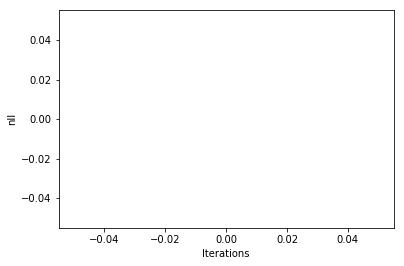

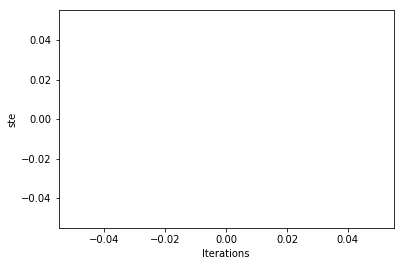

100000 195210000 0.000025 0.000025
101000 195210000 0.000025 0.000025
102000 195210000 0.000025 0.000025
103000 195210000 0.000025 0.000025
104000 195210000 0.000025 0.000025
105000 195210000 0.000025 0.000025
106000 195210000 0.000025 0.000025
107000 195210000 0.000025 0.000025
108000 195210000 0.000025 0.000025
109000 195210000 0.000025 0.000025


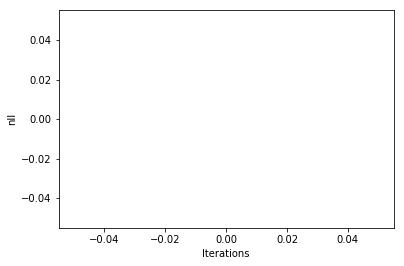

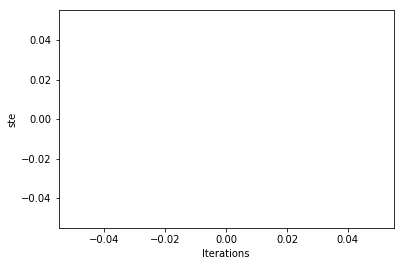

110000 195210000 0.000025 0.000025
111000 195210000 0.000025 0.000025
112000 195210000 0.000025 0.000025
113000 195210000 0.000025 0.000025


KeyboardInterrupt: 

In [78]:
while len(trans_train_logs['loss_evals']) < n_iters:
  demo_batch = sample_batch(batch_size)
  constraint_batch = sample_constraint_batch(constraint_batch_size)
  
  t = len(trans_train_logs['loss_evals'])
  train_log = compute_batch_loss(demo_batch, constraint_batch, trans_only=True, step=True, t=t)
  if val_log is None or len(trans_train_logs['loss_evals']) % val_update_freq == 0:
    val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, trans_only=True, step=False, t=t)
  
  if len(trans_train_logs['loss_evals']) % 1000 == 0:
      print('%d %d %f %f' % (
        t, n_iters, train_log['loss'], val_log['loss'],)
      )
  
  for k, v in train_log.items():
    trans_train_logs['%s_evals' % k].append(v)
  for k, v in val_log.items():
    trans_train_logs['%s%s_evals' % ('val_', k)].append(v)
  if len(trans_train_logs['loss_evals']) % 10000 == 0:
    for k in ['val_nll_evals', 'val_ste_evals']:
      plt.xlabel('Iterations')
      plt.ylabel(k.split('_')[1])
      plt.plot(trans_train_logs[k])
      plt.show()

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.axhline(y=np.mean(ideal_rew), linestyle='--', color='teal', label='Optimal')
plt.axhline(y=np.mean(unassisted_rew), linestyle=':', color='gray', label='Unassisted')
plt.plot(train_logs['assisted_rew_evals'], color='orange', label='Assisted')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('L2 Error')
plt.plot(train_logs['int_dyn_err_evals'], color='orange')
plt.ylim([-0.05, None])
plt.show()

In [79]:
print(sess.run(int_dyn_A))

[[1.         0.         0.9984871  0.        ]
 [0.         1.         0.         0.9984871 ]
 [0.         0.         0.98677444 0.        ]
 [0.         0.         0.         0.98677444]]


In [80]:
print(sess.run(int_dyn_B))

[[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]]


repeat with ten different random seeds

In [ ]:
master_train_logs = []

In [ ]:
for _ in range(10):
  train_constraint_example_idxes = None
  val_constraint_batch = None
  constraint_obs_t = None
  constraint_act_t = None
  constraint_act_t_feats = None
  n_iters_since_prev_constraint_sample = 0
  tf.global_variables_initializer().run(session=sess)
  
  n_iters = 20000
  train_logs = {
    'loss_evals': [],
    'nll_evals': [],
    'ste_evals': [],
    'val_loss_evals': [],
    'val_nll_evals': [],
    'val_ste_evals': [],
    'assisted_rew_evals': [],
    'assisted_succ_evals': [],
    'assisted_crash_evals': [],
    'int_dyn_err_evals'
  }
  
  val_log = None
  while len(train_logs['loss_evals']) < n_iters:
    demo_batch = sample_batch(batch_size)
    constraint_batch = sample_constraint_batch(constraint_batch_size)

    t = len(train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraint_batch, step=True, t=t)
    if val_log is None or t % val_update_freq == 0:
      val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, step=False, t=t)

    if t % 1000 == 0:
      print('%d %d %f %f %f %f %f %f %f' % (
        t, n_iters, train_log['loss'],
        train_log['nll'], train_log['ste'], val_log['loss'],
        val_log['nll'], val_log['ste'], val_log['int_dyn_err'])
      )

    for k, v in train_log.items():
      train_logs['%s_evals' % k].append(v)
    for k, v in val_log.items():
      train_logs['%s%s_evals' % ('val_' if k in ['loss', 'nll', 'ste'] else '', k)].append(v)
      
  master_train_logs.append(train_logs)

In [ ]:
with open(os.path.join(data_dir, 'master_train_logs.pkl'), 'wb') as f:
  pickle.dump(master_train_logs, f, pickle.HIGHEST_PROTOCOL)

internal2real dynamics transfer

In [ ]:
newton_env = train_newton_envs[0].unwrapped
def inverse_real_dyn(state, next_state, vel_thresh=accel):#=1e-9):#
  pos = state[:2]
  vel = state[2:]
  next_states = np.array([newton_env._obs_of_pos_vel(*newton_env._next_pos_vel(pos, vel, a)) for a in range(n_act_dim)])
  if (np.abs(state[2:]) <= vel_thresh).all():
    dists = np.linalg.norm(next_state[:2] - next_states[:, :2], axis=1)
  else:
    dists = np.linalg.norm(next_state[2:] - next_states[:, 2:], axis=1)
  return np.argmax(-dists)

In [ ]:
def dyn_transfer(state, action):
  act_feats = np.array([featurize_act(action)])
  obs_feats = np.array([featurize_obs(state)])
  feed_dict = {
    samp_obs_t_ph: obs_feats,
    samp_act_t_feats_ph: act_feats
  }
  next_state = sess.run(samp_obs_tp1, feed_dict=feed_dict)[0]
  return inverse_real_dyn(state, next_state)

In [ ]:
def make_assisted_env(goal=None):
  test_goal = np.random.random(2) if goal is None else goal
  test_reward_func = make_reward_func(test_goal)
  test_aristotle_pilot_policy = make_aristotle_pilot_policy(test_goal, denoise=True)
  env = PointMassNav(reward_func=test_reward_func, goal=test_goal, using_inertia=True)
  env.unwrapped._step_orig = env.unwrapped.step
  def step(self, action):
    transferred_act = dyn_transfer(self.curr_obs, action)
    obs, r, done, info = self._step_orig(transferred_act)
    return obs, r, done, info
  env.unwrapped.step = types.MethodType(step, env.unwrapped)
  return test_aristotle_pilot_policy, env

In [ ]:
def make_env_without_dyn_transfer(using_inertia=True, goal=None):
  test_goal = np.random.random(2) if goal is None else goal
  test_reward_func = make_reward_func(test_goal)
  test_aristotle_pilot_policy = make_aristotle_pilot_policy(test_goal, denoise=True)
  unassisted_env = PointMassNav(using_inertia=using_inertia, reward_func=test_reward_func, goal=test_goal)
  return test_aristotle_pilot_policy, unassisted_env

In [ ]:
make_unassisted_env = lambda: make_env_without_dyn_transfer(using_inertia=True)
make_ideal_env = lambda: make_env_without_dyn_transfer(using_inertia=False)

In [ ]:
n_eval_rollouts = 1000

In [ ]:
assisted_rollouts = [run_ep(*make_assisted_env(), render=False) for _ in range(n_eval_rollouts)]

In [ ]:
with open(os.path.join(data_dir, 'aristotle_pilot_policy_assisted_rollouts.pkl'), 'wb') as f:
  pickle.dump(assisted_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(data_dir, 'aristotle_pilot_policy_assisted_rollouts.pkl'), 'rb') as f:
  assisted_rollouts = pickle.load(f)

In [ ]:
unassisted_rollouts = [run_ep(*make_unassisted_env(), render=False) for _ in range(n_eval_rollouts)]

In [ ]:
with open(os.path.join(data_dir, 'aristotle_pilot_policy_unassisted_rollouts.pkl'), 'wb') as f:
  pickle.dump(unassisted_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(data_dir, 'aristotle_pilot_policy_unassisted_rollouts.pkl'), 'rb') as f:
  unassisted_rollouts = pickle.load(f)

In [ ]:
ideal_rollouts = [run_ep(*make_ideal_env(), render=False) for _ in range(n_eval_rollouts)]

In [ ]:
with open(os.path.join(data_dir, 'aristotle_pilot_policy_ideal_rollouts.pkl'), 'wb') as f:
  pickle.dump(ideal_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(data_dir, 'aristotle_pilot_policy_ideal_rollouts.pkl'), 'rb') as f:
  ideal_rollouts = pickle.load(f)

In [ ]:
unassisted_rew = [sum(x[2] for x in r) for r in unassisted_rollouts]
ideal_rew = [sum(x[2] for x in r) for r in ideal_rollouts]

In [ ]:
assisted_rew = [sum(x[2] for x in r) for r in assisted_rollouts]

In [ ]:
np.mean(unassisted_rew), np.mean(ideal_rew)

In [ ]:
np.mean(assisted_rew)

In [ ]:
unassisted_succ = [1 if is_succ(r) else 0 for r in unassisted_rollouts]
ideal_succ = [1 if is_succ(r) else 0 for r in ideal_rollouts]

In [ ]:
assisted_succ = [1 if is_succ(r) else 0 for r in assisted_rollouts]

In [ ]:
np.mean(unassisted_succ), np.mean(ideal_succ)

In [ ]:
np.mean(assisted_succ) 

In [ ]:
unassisted_crash = [1 if is_crash(r) else 0 for r in unassisted_rollouts]
ideal_crash = [1 if is_crash(r) else 0 for r in ideal_rollouts]

In [ ]:
assisted_crash = [1 if is_crash(r) else 0 for r in assisted_rollouts]

In [ ]:
np.mean(unassisted_crash), np.mean(ideal_crash)

In [ ]:
np.mean(assisted_crash)

viz trajectories

In [ ]:
def plot_trajectories(
  rollouts, goal, title, file_name=None):
  plt.title(title)

  for rollout in rollouts:
    trajectory = [x[0] for x in rollout] + [rollout[-1][3]]
    x, y, vx, vy = list(zip(*trajectory))
    if is_succ(rollout):
      cmap = mpl.cm.YlGn
    elif is_crash(rollout):
      cmap = mpl.cm.YlOrRd
    else:
      cmap = mpl.cm.gray
    plt.scatter(x, y, c=range(len(x)), cmap=cmap, alpha=0.75, linewidth=0)
    plt.scatter(
      [goal[0]], [goal[1]], marker='*', color='yellow', 
      edgecolor='black', linewidth=1, s=300, alpha=0.5)
    
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  if file_name is not None:
    plt.savefig(os.path.join(data_dir, file_name), bbox_inches='tight')
  plt.show()

In [ ]:
n_viz_rollouts = 100
center_goal = np.array([0.5, 0.5])

In [ ]:
test_aristotle_pilot_policy, assisted_env = make_assisted_env(goal=center_goal)
assisted_rollouts = [run_ep(
  test_aristotle_pilot_policy, assisted_env, render=False) for _ in range(n_viz_rollouts)]

In [ ]:
test_aristotle_pilot_policy, unassisted_env = make_env_without_dyn_transfer(
  using_inertia=True, goal=center_goal)
unassisted_rollouts = [run_ep(
  test_aristotle_pilot_policy, unassisted_env, render=False) for _ in range(n_viz_rollouts)]

In [ ]:
unassisted_rollouts_sample = random.sample(unassisted_rollouts, 10)

In [ ]:
mpl.rcParams.update({'font.size': 20})

In [ ]:
plot_trajectories(
  unassisted_rollouts_sample, center_goal, 'Unassisted', 'unassisted-traj.pdf')

In [ ]:
assisted_rollouts_sample = random.sample(assisted_rollouts, 20)

In [ ]:
plot_trajectories(assisted_rollouts_sample, center_goal, 'Assisted', 'assisted-traj.pdf')

In [ ]:
run_ep(test_aristotle_pilot_policy, assisted_env, render=True)

In [ ]:
assisted_env.close()

viz master logs

In [ ]:
with open(os.path.join(data_dir, 'master_train_logs.pkl'), 'rb') as f:
  master_train_logs = pickle.load(f)

In [ ]:
def err_vs_iter_of_logs(master_train_logs):
  n_reps = len(master_train_logs)
  max_iter = max(len(
    train_logs['int_dyn_err_evals']) for train_logs in master_train_logs)
  R = np.zeros((n_reps, max_iter))
  R[:, :] = np.nan
  for i, train_logs in enumerate(master_train_logs):
    errs = train_logs['int_dyn_err_evals']
    R[i, :len(errs)] = errs
  return R

In [ ]:
smooth_win = 100
def moving_avg(d, n=smooth_win):
  s = np.concatenate((np.zeros(1), np.cumsum(d).astype(float)))
  return (s[n:] - s[:-n]) / n

In [ ]:
traj_col_means = lambda x: np.nanmean(x, axis=0)
traj_col_stderrs = lambda x: np.nanstd(x, axis=0) / np.sqrt(
  np.count_nonzero(~np.isnan(x), axis=0))
r_mins = lambda x: traj_col_means(x) - traj_col_stderrs(x)
r_maxs = lambda x: traj_col_means(x) + traj_col_stderrs(x)

In [ ]:
R = err_vs_iter_of_logs(master_train_logs)

In [ ]:
def plot_fill(R, color, label):
  x = range(R.shape[1] - (smooth_win - 1))
  y1 = moving_avg(r_mins(R), n=smooth_win)
  y2 = moving_avg(r_maxs(R), n=smooth_win)
  plt.fill_between(
    x, y1, y2, where=y2 >= y1, interpolate=True, facecolor=color, alpha=0.5)
  plt.plot(moving_avg(traj_col_means(R), n=smooth_win), color=color, label=label)

In [ ]:
plt.xlabel('Number of Gradient Steps')
plt.ylabel('Internal Dynamics L2 Error')
plt.title('2D Continuous-State Navigation')

plot_fill(R, 'orange', 'Our Method')

plt.axhline(y=0.25, linestyle='--', color='gray', label='Random')

plt.ylim([-0.05, None])
plt.xlim([0, 10000])
plt.legend(loc='best')
plt.savefig(os.path.join(data_dir, 'err-vs-iter.pdf'), bbox_inches='tight')
plt.show()